## PreProcess Images and feed into CNN

In [0]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# Install package to handle .tiff data
!pip install pyrsgis

In [0]:
# Clone my git repo for preprocessing the images
!git clone https://github.com/maxjonasbehrens/master_thesis_code
#%cd /content/master_thesis_code
#!git pull

Cloning into 'master_thesis_code'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 710 (delta 29), reused 40 (delta 18), pack-reused 649
Receiving objects: 100% (710/710), 14.74 MiB | 9.99 MiB/s, done.
Resolving deltas: 100% (389/389), done.


In [0]:
# Load Python script for preprocessing
%load /content/master_thesis_code/NeuralNetTrain/imgProcessing/sat_images.py

In [0]:
# Load necessary packages
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import pyrsgis
import cv2
from skimage.transform import resize
from PIL import Image
%matplotlib inline 
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import scipy.io
import sklearn.model_selection
import imageio

Warning! matplotlib_scalebar library not found.


In [0]:
# Import own module to preprocess images
import imp
sat_images = imp.new_module('sat_images')
exec(open("/content/master_thesis_code/NeuralNetTrain/imgProcessing/sat_images.py").read(), sat_images.__dict__)

## Test for one image

In [0]:
# Download test image from drive
img_path = "/gdrive/My Drive/ThesisData/training/night_country/TR52_7300.0_2013.png"

img = imageio.imread(img_path)

In [0]:
# Print its shape
print("Image shape: ",img.shape)

Image shape:  (4464, 4023, 3)


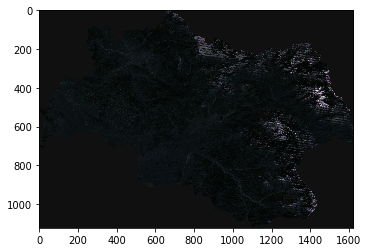

In [0]:
# Show the original image
plt.imshow(img, interpolation='nearest')
plt.show()

# Create input data

In [0]:
# Load Data Frame of NUTS regions and corresponding gdp values
y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/enhanced_gdp_data.csv")
y_dat.head()

,nuts2,year,nuts_value,code,country,country_value,mean_value,nuts_diff,ppp
0,BG31,2014,3800.0,BG,Bulgaria,5900.0,5266.666667,-2100.0,30.0
1,BG32,2014,4300.0,BG,Bulgaria,5900.0,5266.666667,-1600.0,34.0
2,BG33,2014,5000.0,BG,Bulgaria,5900.0,5266.666667,-900.0,40.0
3,BG34,2014,5000.0,BG,Bulgaria,5900.0,5266.666667,-900.0,40.0
4,BG41,2014,9500.0,BG,Bulgaria,5900.0,5266.666667,3600.0,75.0


In [0]:
# Benchmark for diff-value (other benchmark are in other script)
mae_diff = np.mean(abs(y_dat['nuts_diff']-y_dat['nuts_diff'].mean()))
print(mae_diff)

In [0]:
# List of all files in directory of images
mypath = "/gdrive/My Drive/nuts_viirs/"
mypath_day = "/gdrive/My Drive/nuts_geotiff/"
sat_images.create_save_data(mypath,y_dat,prediction='nuts_value',kind='normal',replace_nan='mean',resolution=1024,night=True)

In [0]:
# List of all files in directory of images
mypath = "/gdrive/My Drive/nuts_viirs/"
sat_images.create_time_data(mypath,y_dat,replace_nan='mean')

Region processed:  0  of  292


## Fit Linear Model for Benchmarking Results

In [0]:
from os import listdir
from os.path import isfile, join, getsize
import numpy as np
from sklearn.linear_model import LinearRegression

train_path = "/gdrive/My Drive/ThesisData/training/viirs_night/"
val_path = "/gdrive/My Drive/ThesisData/validation/viirs_night/"
test_path = "/gdrive/My Drive/ThesisData/test/viirs_night/"

train_files = [f for f in listdir(train_path) if isfile(join(train_path, f))]
val_files = [f for f in listdir(val_path) if isfile(join(val_path, f))]
test_files = [f for f in listdir(test_path) if isfile(join(test_path, f))]

y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/enhanced_gdp_data.csv")
test_f = val_files + test_files

X_train = []
X_test = []
y_train_diff = []
y_test_diff = []
y_train_abs = []
y_test_abs = []

for f in train_files:
  region = f.rsplit('_')[0]
  year = int(f.rsplit('_')[2].rsplit('.')[0])
  mean = float(f.rsplit('_')[1])
  X_train.append(mean)
  y_train_diff.append(y_dat.loc[(y_dat['nuts2']==region)&(y_dat['year']==year),'nuts_diff'].values[0])
  y_train_abs.append(y_dat.loc[(y_dat['nuts2']==region)&(y_dat['year']==year),'nuts_value'].values[0])

for f in test_f:
  region = f.rsplit('_')[0]
  year = int(f.rsplit('_')[2].rsplit('.')[0])
  mean = float(f.rsplit('_')[1])
  X_test.append(mean)
  y_test_diff.append(y_dat.loc[(y_dat['nuts2']==region)&(y_dat['year']==year),'nuts_diff'].values[0])
  y_test_abs.append(y_dat.loc[(y_dat['nuts2']==region)&(y_dat['year']==year),'nuts_value'].values[0])

X_train = np.array([X_train])
X_test = np.array([X_test])
y_train = np.array([y_train])
y_test = np.array([y_test])

print('Train X: ',str(X_train[0][:3]))
print('Test X: ',str(X_test[0][:3]))

Train X:  [1.1798692 5.681597  0.9433991]
Test X:  [0.4845261  1.354468   0.76528424]


In [0]:
X_train = np.swapaxes(X_train,0,-1)
X_test = np.swapaxes(X_test,0,-1)
y_train_abs = np.swapaxes(y_train_abs,0,-1)
y_test_abs = np.swapaxes(y_test_abs,0,-1)
y_train_diff = np.swapaxes(y_train_diff,0,-1)
y_test_diff = np.swapaxes(y_test_diff,0,-1)
print(X_train.shape)

(666, 1)


In [0]:
reg = LinearRegression().fit(X_train, y_train_diff)
r_square = reg.score(X_train, y_train_diff)
print('R Square Difference: ',str(r_square))
pred = reg.predict(X_test)
mse = np.mean((y_test_diff-pred)**2)
mae = np.mean(np.abs(y_test_diff-pred))
print('MSE Difference: ',str(mse))
print('MAE Difference: ',str(mae))

R Square Difference:  0.24170259663548802
MSE Difference:  58910554.68916116
MAE Difference:  5005.877781759081


In [0]:
reg = LinearRegression().fit(X_train, y_train_abs)
r_square = reg.score(X_train, y_train_abs)
print('R Square Absolute: ',str(r_square))
pred = reg.predict(X_test)
mse = np.mean((y_test_abs-pred)**2)
mae = np.mean(np.abs(y_test_abs-pred))
print('MSE Absolute: ',str(mse))
print('MAE Absolute: ',str(mae))

R Square Absolute:  0.19111783848136998
MSE Absolute:  174987925.53659624
MAE Absolute:  11008.906778354532


## Sample CNN Architectures

In [0]:
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import GaussianDropout
from keras.layers import GaussianNoise
from keras.regularizers import l1, l2, l1_l2
from keras.optimizers import SGD, Adam, Nadam, Adamax, Adadelta, RMSprop
from keras.applications import VGG19, ResNet50, ResNet50V2, InceptionResNetV2, MobileNetV2
from keras.callbacks import EarlyStopping
import scipy
import pandas as pd
import numpy as np
from datetime import date
from os import listdir
import itertools
from os.path import isfile, join, getsize
#Image.MAX_IMAGE_PIXELS = 213437725

Using TensorFlow backend.


In [0]:
in_shape = (256,256,3)
out_shape = 1

In [0]:
# Very shallow CNN
xs_model = Sequential()

xs_model.add(Conv2D(32, 3, padding='same', input_shape=in_shape, activation='relu'))
xs_model.add(Flatten())
#xs_model.add(Dense(128, activation='relu'))
xs_model.add(Dense(units=out_shape,activation='linear'))

In [0]:
# Very shallow CNN
s_model = Sequential()

s_model.add(Conv2D(32, 3, padding='same', input_shape=in_shape, activation='relu'))
s_model.add(Conv2D(32, 3, padding='same', activation='relu'))
s_model.add(BatchNormalization())
s_model.add(MaxPooling2D(pool_size = (2,2)))

s_model.add(Flatten())
s_model.add(Dense(128, activation='relu', activity_regularizer=l1(0.001)))
s_model.add(Dropout(0.5))
s_model.add(Dense(units=out_shape,activation='linear'))










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Med Shallow Model
m_model = Sequential()

m_model.add(Conv2D(16, 3, padding='same', input_shape=in_shape, activation='relu'))
m_model.add(Conv2D(16, 3, padding='same', activation='relu'))
m_model.add(BatchNormalization())
m_model.add(MaxPooling2D(pool_size = (2,2)))

m_model.add(Conv2D(32, 3, padding='same', activation='relu'))
m_model.add(Conv2D(32, 3, padding='same', activation='relu'))
m_model.add(BatchNormalization())
m_model.add(MaxPooling2D(pool_size = (2,2)))

m_model.add(Flatten())
m_model.add(Dense(128, activation='relu', activity_regularizer=l1(0.001)))
m_model.add(Dropout(0.5))

m_model.add(Dense(256, activation='relu',activity_regularizer=l1(0.001)))
m_model.add(Dropout(0.5))
m_model.add(Dense(units=out_shape,activation='linear'))

In [0]:
# Deep Model
l_model = Sequential()

l_model.add(Conv2D(32, 3, padding='same', input_shape=in_shape, activation='relu'))
l_model.add(Conv2D(32, 3, padding='same', activation='relu'))
l_model.add(BatchNormalization())
l_model.add(MaxPooling2D(pool_size = (2,2)))

l_model.add(Conv2D(64, 3, padding='same', activation='relu'))
l_model.add(Conv2D(64, 3, padding='same', activation='relu'))
l_model.add(BatchNormalization())
l_model.add(MaxPooling2D(pool_size = (2,2)))

l_model.add(Conv2D(128, 3, padding='same', activation='relu'))
l_model.add(Conv2D(128, 3, padding='same', activation='relu'))
l_model.add(Dropout(0.4))
l_model.add(BatchNormalization())
l_model.add(MaxPooling2D(pool_size = (2,2)))

l_model.add(Conv2D(256, 3, padding='same', activation='relu'))
l_model.add(Conv2D(256, 3, padding='same', activation='relu'))
l_model.add(Dropout(0.4))
l_model.add(BatchNormalization())
l_model.add(MaxPooling2D(pool_size = (2,2)))

l_model.add(Conv2D(512, 3, padding='same', activation='relu'))
l_model.add(Conv2D(512, 3, padding='same', activation='relu'))
l_model.add(Dropout(0.4))
l_model.add(BatchNormalization())
l_model.add(MaxPooling2D(pool_size = (2,2)))

l_model.add(Flatten())
l_model.add(Dense(256, activation='relu', activity_regularizer=l1(0.001)))
l_model.add(Dropout(0.5))

l_model.add(Dense(256, activation='relu',activity_regularizer=l1(0.001)))
l_model.add(Dropout(0.5))
l_model.add(Dense(units=out_shape,activation='linear'))

In [0]:
# Transfer Learning
base_model = ResNet50(input_shape=in_shape,include_top=False)

x=base_model.output
x=Flatten()(x)
x=Dense(32,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.2)(x) #Dropout
x=Dense(32,activation='relu')(x) #dense layer 3
x=Dropout(0.2)(x) #Dropout
preds=Dense(units=out_shape, activation = 'linear')(x)
resnet_model=Model(inputs=base_model.input,outputs=preds)

for layer in resnet_model.layers[:-26]:
	layer.trainable = False


94658560/94653016 [==============================] - 1s 0us/step


In [0]:
# Transfer Learning
base_model = VGG19(input_shape=in_shape,include_top=False)

x=base_model.output
x=Flatten()(x)
x=Dense(32,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.2)(x) #Dropout
x=Dense(32,activation='relu')(x) #dense layer 3
x=Dropout(0.2)(x) #Dropout
preds=Dense(units=out_shape, activation = 'linear')(x)
vgg_model=Model(inputs=base_model.input,outputs=preds)

80142336/80134624 [==============================] - 1s 0us/step


In [0]:
# Transfer Learning
base_model = MobileNetV2(input_shape=in_shape,include_top=False)

x=base_model.output
x=Flatten()(x)
x=Dense(32,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.2)(x) #Dropout
x=Dense(32,activation='relu')(x) #dense layer 3
x=Dropout(0.2)(x) #Dropout
preds=Dense(units=out_shape, activation = 'linear')(x)
mobile_model=Model(inputs=base_model.input,outputs=preds)

for layer in mobile_model.layers[:-26]:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
# Transfer Learning
base_model = InceptionResNetV2(input_shape=in_shape,include_top=False)

x=base_model.output
x=Flatten()(x)
x=Dense(32,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.2)(x) #Dropout
x=Dense(32,activation='relu')(x) #dense layer 3
x=Dropout(0.2)(x) #Dropout
preds=Dense(units=out_shape, activation = 'linear')(x)
inception_model=Model(inputs=base_model.input,outputs=preds)


219062272/219055592 [==============================] - 3s 0us/step


# Training Pipeline for CNN Fitting

In [0]:
# Plot histogram of image size in different sets
train_path = "/gdrive/My Drive/ThesisData/training/viirs_night/"
val_path = "/gdrive/My Drive/ThesisData/validation/viirs_night/"
test_path = "/gdrive/My Drive/ThesisData/test/viirs_night/"

train_files = [getsize(join(train_path, f)) for f in listdir(train_path) if isfile(join(train_path, f))]
val_files = [getsize(join(val_path, f)) for f in listdir(val_path) if isfile(join(val_path, f))]
test_files = [getsize(join(test_path, f)) for f in listdir(test_path) if isfile(join(test_path, f))]

pyplot.hist(train_files,bins=1000)
pyplot.show()

pyplot.hist(val_files,bins=1000)
pyplot.show()

pyplot.hist(test_files,bins=1000)
pyplot.show()

In [0]:
# Create DataFrame to load the data
def data_load(data_type, pred = 'nuts_value'):
  
  train_path = "/gdrive/My Drive/ThesisData/training/"+str(data_type)+"/"
  val_path = "/gdrive/My Drive/ThesisData/validation/"+str(data_type)+"/"
  test_path = "/gdrive/My Drive/ThesisData/test/"+str(data_type)+"/"

  train_files = [f for f in listdir(train_path) if isfile(join(train_path, f)) and getsize(join(train_path, f)) > 100]
  val_files = [f for f in listdir(val_path) if isfile(join(val_path, f)) and getsize(join(val_path, f)) > 100]
  test_files = [f for f in listdir(test_path) if isfile(join(test_path, f)) and getsize(join(test_path, f)) > 100]

  if pred == 'diff':
    y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/gdp_time_series.csv")
  else:
    y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/enhanced_gdp_data.csv")

  train_y = []
  val_y = []
  test_y = []


  for f in train_files:
    if pred == 'diff':
      year = f.rsplit('_')[1].rsplit('.')[0]
      region = f.rsplit('_')[0]
      train_y.append(y_dat.loc[(y_dat['nuts2']==region),str('diff_'+year)].values[0])
    else:
      year = int(f.rsplit('_')[2].rsplit('.')[0])
      region = f.rsplit('_')[0]
      train_y.append(y_dat.loc[(y_dat['nuts2']==region)&(y_dat['year']==year),pred].values[0])

  for f in val_files:
    if pred == 'diff':
      year = f.rsplit('_')[1].rsplit('.')[0]
      region = f.rsplit('_')[0]
      val_y.append(y_dat.loc[(y_dat['nuts2']==region),str('diff_'+year)].values[0])
    else:
      year = int(f.rsplit('_')[2].rsplit('.')[0])
      region = f.rsplit('_')[0]
      val_y.append(y_dat.loc[(y_dat['nuts2']==region)&(y_dat['year']==year),pred].values[0])

  for f in test_files:
    if pred == 'diff':
      year = f.rsplit('_')[1].rsplit('.')[0]
      region = f.rsplit('_')[0]
      test_y.append(y_dat.loc[(y_dat['nuts2']==region),str('diff_'+year)].values[0])
    else:
      year = int(f.rsplit('_')[2].rsplit('.')[0])
      region = f.rsplit('_')[0]
      test_y.append(y_dat.loc[(y_dat['nuts2']==region)&(y_dat['year']==year),pred].values[0])

  train_df = pd.DataFrame({'y':train_y,'file':train_files})
  val_df = pd.DataFrame({'y':val_y,'file':val_files})
  test_df = pd.DataFrame({'y':test_y,'file':test_files})

  return train_df, val_df, test_df

In [0]:
# define cnn model
def define_model(lr,in_shape, out_shape,optim,model):
		
	# compile model
	if optim == 'adam':
		opt = Adam(lr=lr)
	elif optim == 'sgd':
		opt = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
	elif optim == 'rmsprob':
		opt = RMSprop(lr=lr, rho=0.9)
	else:
		opt = Adamax(lr=lr)
 
	model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mse','mae','mape'])
 
	return model

In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history,no_layers,in_shape,batch_size,epochs,mse,mae,transfer,lr,optim,comment,data_type,pred):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Model MSE')
	pyplot.plot(history.history['mean_squared_error'], color='blue', label='train')
	pyplot.plot(history.history['val_mean_squared_error'], color='orange', label='val')
	pyplot.xlabel("")
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Model MAE')
	pyplot.plot(history.history['mean_absolute_error'], color='blue', label='train')
	pyplot.plot(history.history['val_mean_absolute_error'], color='orange', label='val')
	# save plot to file
	day = date.today()
	filename = str(day)+"_"+str(in_shape[0])+"_"+str(in_shape[2])+"_"+str(epochs)+"_"+str(batch_size)
	#pyplot.savefig('/gdrive/My Drive/ThesisData/cnn_results/'+filename + '_plot.png')
	pyplot.close()
  
	# write diagnostics to results file
	myrow = ['\n'+str(day),str(no_layers),str(batch_size),str(epochs),str(in_shape[0]),str(in_shape[2]),
	         str(history.history['mean_squared_error'][-1]),str(history.history['mean_absolute_error'][-1]),
					     str(history.history['val_mean_squared_error'][-1]),str(history.history['val_mean_absolute_error'][-1]),
							   str(mse),str(mae),str(transfer),str(lr),str(optim),str(comment),str(data_type),str(pred),str(history.history['val_mean_absolute_percentage_error'][-1])]
	myrow = ','.join(myrow)
	filepath = '/gdrive/My Drive/ThesisData/cnn_results/cnn_results.csv'
	with open(filepath,'a') as fd:
		fd.write(myrow)

In [0]:
# run the test harness for evaluating a model
def run_test_harness(comment,transfer,optim,model,data_type,lr=0.0001,batch_size = 10,epochs = 50, target_size = 128, pred = 'nuts_value'):
  
  # load dataset
  train_df, val_df, test_df = data_load(data_type=data_type, pred = pred)
  
  # create data generator
  train_datagen = ImageDataGenerator()#rescale=(1.0/256))
  val_datagen = ImageDataGenerator()#rescale=(1.0/256))
  test_datagen = ImageDataGenerator()#rescale=(1.0/256))

  # Define early stopping
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=30, restore_best_weights=True)

  # File Directories
  train_path = "/gdrive/My Drive/ThesisData/training/"+str(data_type)
  val_path = "/gdrive/My Drive/ThesisData/validation/"+str(data_type)
  test_path = "/gdrive/My Drive/ThesisData/test/"+str(data_type)

  # Infer color mode and input shape
  if 'day' in data_type or 'night' in data_type or data_type == 'subsample':
    color_mode = 'rgb'
    in_shape = (target_size,target_size,3)
  else:
    color_mode = 'rgba'
    in_shape = (target_size,target_size,4)

  print(in_shape)

  # prepare iterators
  train_it = train_datagen.flow_from_dataframe(train_df,
                                               directory=train_path,
                                               x_col = 'file',
                                               y_col = 'y',
                                               target_size = (target_size,target_size),
                                               batch_size = batch_size,
                                               class_mode = 'raw',
                                               color_mode = color_mode)
  
  val_it = val_datagen.flow_from_dataframe(val_df, 
                                           directory=val_path,
                                           x_col = 'file',
                                           y_col = 'y',
                                           target_size = (target_size,target_size),
                                           batch_size = batch_size,
                                           class_mode = 'raw',
                                           color_mode = color_mode)
  
  test_it = test_datagen.flow_from_dataframe(test_df, 
                                             directory=test_path,
                                             x_col = 'file',
                                             y_col = 'y',
                                             target_size = (target_size,target_size),
                                             batch_size = batch_size,
                                             class_mode = 'raw',
                                             color_mode = color_mode)
  
  # define model
  model = define_model(lr=lr,in_shape=in_shape,out_shape=1,optim=optim,model=model)
  no_layers = len(model.layers)

  if no_layers == 3:
    transfer = 'xs_model'
  elif no_layers == 8:
    transfer = 's_model'
  elif no_layers == 14:
    transfer = 'm_model'
  elif no_layers == 29:
    transfer = 'l_model'
  elif no_layers == 181:
    transfer = 'resnet_model'
  elif no_layers == 28:
    transfer = 'vgg_model'
  elif no_layers == 161:
    transfer = 'mobile_model'
  else:
    transfer = 'inception_model'

  print('Model: '+transfer)
  
  # fit model
  history = model.fit_generator(train_it, 
                                steps_per_epoch=len(train_it),
                                validation_data=val_it, 
                                validation_steps=len(val_it),
                                callbacks = [es], 
                                epochs=epochs, 
                                verbose=2)
  
  # evaluate model
  loss, mse, mae, mape = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
  print('> mse=%.3f, mae=%.3f' % (mse, mae))
  
  # learning curves
  summarize_diagnostics(history=history,
                        no_layers=no_layers,
                        in_shape = in_shape,
                        batch_size=batch_size,
                        epochs=len(history.history['loss']),
                        mse=mse,mae=mae,
                        transfer=transfer,lr=lr,
                        optim=optim,
                        comment=comment,
                        data_type=data_type,
                        pred = pred)
  
  return model, test_it

In [0]:
models = [inception_model,mobile_model, resnet_model, vgg_model]
optims = ["adam","sgd","rmsprob","adamax"]
lrs = [0.001,0.0001,0.00001,0.000001]
opt_list = list(itertools.product(models,optims,lrs))
print(len(opt_list))

64


In [0]:
i = 2
for combi in opt_list[2:]:
  print(combi)
  print(i)
  model, test_it = run_test_harness("iterated nn","missing",combi[1],combi[0],data_type='viirs_night',lr=combi[2],batch_size=8,epochs=1000,target_size=in_shape[0], pred='nuts_diff')
  i = i+1

(<keras.engine.training.Model object at 0x7fa516ef8f28>, 'adam', 1e-05)
2
(256, 256, 3)
Found 666 validated image filenames.
Found 216 validated image filenames.
Found 246 validated image filenames.
Model: inception_model
Epoch 1/1000
 - 171s - loss: 238618649.0031 - mean_squared_error: 238618649.0031 - mean_absolute_error: 6343.7825 - mean_absolute_percentage_error: 11731168.9902 - val_loss: 52536560.9630 - val_mean_squared_error: 52536560.9630 - val_mean_absolute_error: 5447.6009 - val_mean_absolute_percentage_error: 36944062.7887
Epoch 2/1000
 - 25s - loss: 240304207.3398 - mean_squared_error: 240304207.3398 - mean_absolute_error: 6406.1548 - mean_absolute_percentage_error: 33088918.3523 - val_loss: 52527958.6667 - val_mean_squared_error: 52527958.6667 - val_mean_absolute_error: 5446.9254 - val_mean_absolute_percentage_error: 113229036.4104
Epoch 3/1000
 - 25s - loss: 238717521.6205 - mean_squared_error: 238717521.6205 - mean_absolute_error: 6356.3028 - mean_absolute_percentage_erro

In [0]:
model, test_it = run_test_harness("xs model","no","adam",models[0],data_type='viirs_night',lr=0.00001,batch_size=8,epochs=1000,target_size=in_shape[0], pred='nuts_value')

## CNN Optimization Plan

### Optimizer

- SGD
- RMSProb
- Adam

### Overfitting Prevention

- Dropout
- Regulizer
- Batch Normalisation

### Layers

- Very shallow (1 conv, 1 fc)
- Shallow (2 conv, 2 fc)
- Medium shallow
- Deep

### Transfer Learning

- ResNet50
- MobileNetV2
- VGG19
- inceptionresnetV2

## Detailed Result Analysis

In [0]:
# Get Predictions for Test Set
test_preds = model.predict_generator(test_it)

In [0]:
# Get Files from Test Set
test_files = test_it.filenames

In [0]:
# Get True Values from Test Set
test_true = test_it.labels

In [0]:
# Check
print('Predictions Length: '+str(len(test_preds)))
print('Files Length: '+str(len(test_files)))
print('True Values Length: '+str(len(test_true)))

Predictions Length: 246
Files Length: 246
True Values Length: 246


In [0]:
res_dict = {'test_preds':list(test_preds[:,0]), 'test_files':list(test_files), 'test_true_vals':list(test_true)}
result_dat = pd.DataFrame(res_dict)
result_dat['country'] = result_dat['test_files'].str[:2]
result_dat['se'] = (result_dat['test_true_vals']-result_dat['test_preds'])**2
result_dat['abs_error'] = abs(result_dat['test_true_vals']-result_dat['test_preds'])
result_dat.head()

,test_preds,test_files,test_true_vals,country,se,abs_error
0,13147.280273,TR52_0.56661737_2014.png,7300.0,TR,3.419069e+07,5847.280273
1,21636.613281,TR63_1.0151527_2014.png,5600.0,TR,2.571730e+08,16036.613281
2,26247.708984,TR72_0.5182273_2014.png,7100.0,TR,3.666348e+08,19147.708984
3,29728.417969,TRA1_0.46649167_2014.png,5900.0,TR,5.677935e+08,23828.417969
4,21382.785156,BG33_0.5070252_2015.png,5200.0,BG,2.618825e+08,16182.785156


In [0]:
result_dat.groupby(['country'])['abs_error'].mean().reset_index().sort_values(['abs_error'])

,country,abs_error
7,FR,6401.005078
6,ES,6724.180664
8,HU,6942.889404
15,PT,7965.619553
5,EL,8231.069971
9,IT,8506.637451
17,SK,8870.850342
11,LV,9009.824219
2,CZ,9159.187866
10,LT,9211.557739
